<center><h1>Rapidly Exploring Random Trees</h1></center>

This document provides a python implementation of RRT, along with some visualizations, tests, and analysis. It was written for testing and learning purposes. Though the python implementation of the algorithm below is correct, you should also primarily use it for learning purposes only. The Java implementation in the parent `javaImplementation` directory is more efficient by virtue of the inherrant properties of the languages, and is what you should use if you're using the path planning library for any intensive search problems.

<b>Note</b>: You might notice that I implement a lot of the functionality in a very object-oriented manner, I do this to make the eventual migration of this logic to Java easier.

In [66]:
import sys
import math
import random
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

For testing purposes, we begin with an implementation of RRT with the search space simply being 2D Cartesian space bounded over some interval (here x and y are limited to values between -15 and 15).

In [2]:
class state2D:
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.dimensionality = 2
        
    def __repr__(self):
        return "REPR: This state is an instante of state2D"
    
    def __str__(self):
        return "({x}, {y})".format(x=self.x, y = self.y)
    
    def getCoordinates(self):
        return (self.x, self.y)

In [3]:
class randomCartesianStateGenerator:
    
    def __init__(self, lower_bounds, upper_bounds, precision):
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.precision = precision
    
    def generate2D(self):
        x = round(random.uniform(self.lower_bounds[0], self.upper_bounds[0]), self.precision)
        y = round(random.uniform(self.lower_bounds[1], self.upper_bounds[1]), self.precision)
        
        return state2D(x, y)

In [4]:
class goalCheckerCartesian:
    """
    Checks if a given state is one of the goal states in an n-dimensional Cartesian search space.
    
    Attributes
    ----------
    goal_states : [STATE_TYPE]
        The set of goal states for the Cartesian search space of interest.
    
    Methods
    -------
    isGoalState(...) : boolean
        Checks if a given 2D Cartesian state is *exactly* one of the goal states.
        
    isGoalStateApproximate() : boolean
        Checks if a given 2D Cartesian state is *appriximately* one of the goal states.
    """
    
    
    def __init__(self, goal_states, tolerable_dimension_error):
        """
        Parameters
        ----------
        goal_states : [STATE_TYPE]
            The set of goal states for the Cartesian search space of interest.
        tolerable_dimension_error : [float]
            This list specifies the tolerable error (inclusive) in every dimension when evaluating a goal state. 
            For instance, if one 2D goal state is (3, 3) and we are asked about (3.1, 2.96) and the 
            error_by_dimension = [0.1, 0.5] then that will be considered a goal state. Not so for (3.11, 2.96).
        """
        self.goal_states = goal_states
        self.tolerable_dimension_error = tolerable_dimension_error
        
    
    def isGoalState(self, cartesianState):
        return cartesianState in goal_states
    
    
    def isGoalStateApproximate(self, test_state):
        """
        Checks if the given state is approximately the same as one of the goal state. "Approximately" is defined
        by an acceptable error rate across every dimension.
        """
        for goal_state in self.goal_states:
            # We will check every dimension and check if state2D dimension n fits within the tolerable error range
            check_results = [False] * test_state.dimensionality
            
            test_state_coordinates = test_state.getCoordinates()
            goal_state_coordinates = goal_state.getCoordinates()            
            
            # Check each dimension at a time if state2D[n] fits within goal[n] +- tolerableError[n]
            for n in range(test_state.dimensionality):
                if (goal_state_coordinates[n] - self.tolerable_dimension_error[n] <= test_state_coordinates[n]) and (test_state_coordinates[n] <= goal_state_coordinates[n] + self.tolerable_dimension_error[n]):
                    check_results[n] = True

            if all(check_results):
                return True

        return False

In [5]:
def euclidean_distance_2D(state2D_1, state2D_2):
    return math.sqrt(((state2D_1.x - state2D_2.x)**2) + ((state2D_1.y - state2D_2.y)**2))

In [6]:
## Testing everyting above
random_state_generator = randomCartesianStateGenerator([-15, -15], [15, 15], 3)

print(random_state_generator.generate2D())
print(random_state_generator.generate2D())
print(random_state_generator.generate2D())

(5.93, -5.979)
(1.341, 8.201)
(13.242, 10.229)


<h3>Printing Tools</h3>

In [42]:
def states_to_cartesian(states):
    x_values = []
    y_values = []

    for state in states:
        x_values.append(state.x)
        y_values.append(state.y)
        
    return (x_values, y_values)

In [76]:
def plot_RRT(tree, goal_states, x_bounds, y_bounds):
    
    fig, ax = plt.subplots()
    
    x = []
    y = []
    n = []
    
    for rrtNode in tree:
        state = rrtNode.state
        state_coordinates = state.getCoordinates()
        x.append(state_coordinates[0])
        y.append(state_coordinates[1])
        n.append(rrtNode.node_number)
        
        for neighbor in rrtNode.neighbors:
            neighbor_state = neighbor.state
            neighbor_state_coordinates = neighbor_state.getCoordinates()
            ax.plot([state_coordinates[0], neighbor_state_coordinates[0]], [state_coordinates[1], neighbor_state_coordinates[1]], 'b')
    
    # Plotting the nodes
    ax.scatter(x, y)
    
    # Annotating the nodes with the number in which they were generated
    for i, txt in enumerate(n):
            ax.annotate(txt, (x[i], y[i]))    

    # Drawing red boxes around goal
    for goal_state in goal_states:
        goal_state_coordinates = goal_state.getCoordinates()
        ax.add_patch(
            patches.Rectangle(
                xy=(goal_state_coordinates[0] - 1, goal_state_coordinates[1] - 1),  # point of origin.
                width=2,    # TODO: This and the one below should be functions of the acceptable error rate
                height=2,
                linewidth=1,
                color='red',
                fill=False
            )
        )
            
    # Axes limits       
    plt.ylim(y_bounds) 
    plt.xlim(x_bounds) 

    # Plot and axis lables/titles
    plt.xlabel('x') 
    plt.ylabel('y') 
    plt.title('RRT Graph') 

    # Showing the plot
    plt.show() 

<h3>RRT Implementation</h3>

<h2>Pseudo code</h2>

    EPSILON = max length of an edge in the tree;
    K = max number of nodes in the tree;

    rrt(start,end){
	    startNode = new Node at start;
	    startTree = new RRTree(startNode);
	    endNode = new Node at end;
	    endTree = new RRTree(endNode);

	    return makePath(startTree,endTree);	
    }

    makePath(t1,t2){
	    qRandom = new Node at random location;
	    qNear = nearest node to qRandom in t1;
	    qNew = new Node EPSILON away from qNear in direction of qRandom;

	    t1.add(qNew);
	    if(there's a path from qNew to the closest node in t2) {
		    path = path from qNew to root of t1;
		    path.append(path from qNew to root of t2);
		    return path;
	    } else if(size(t1) < K) {
		    return makePath(t2,t1);
	    } else {
		    return FAIL;
	    }
    }

In [77]:
class RRTNode:
    
    def __init__(self, state, node_number):
        self.state = state
        self.node_number = node_number
        self.neighbors = []

        
    def addNeighbor(self, neighbor):
        self.neighbors.append(neighbor)
        
    def __str__(self):
        state_coordinates = self.state.getCoordinates()
        neighbor_coordinates = []
        for neighbor in self.neighbors:
            neighbor_coordinates.append(neighbor.state.getCoordinates())
        return "({sub1}) --- neighbors: [{sub2}]".format(sub1=state_coordinates, sub2=neighbor_coordinates)

In [78]:
class RapidRandomTrees:
    
    def __init__(self, growth_factor, max_num_nodes, start_state, goal_states, state_generator, goal_checker):
        self.growth_factor = growth_factor
        self.max_num_nodes = max_num_nodes
        self.start_state = start_state
        self.goal_states = goal_states
        self.state_generator = state_generator
        self.goal_checker = goal_checker
        
        # Initializing the Tree with just the start node
        self.tree = [RRTNode(start_state, 0)]
        

    def findNearestTreeNode(self, random_state):
        # Iterate through all nodes in the tree to find the closest one
        closest_tree_node = None
        smallest_distance = sys.float_info.max
        
        for tree_node in self.tree:
            distance = euclidean_distance_2D(tree_node.state, random_state)
            if (distance < smallest_distance):
                closest_tree_node = tree_node
                smallest_distance = distance
                
        #print('New state: ({one}) -- Nearest state: ({two})'.format(one=random_state.getCoordinates(), two=closest_tree_node.state.getCoordinates()))
        return closest_tree_node


    def searchNoGrowthFactor(self):
        """
        Performs RRT without using a growth factor, i.e. as long as a newly generated state is within the line of sight
        of its nearest node on the tree, and vice versa, it will be added to the tree.
        """
        curr_num_nodes = 0;
        
        while curr_num_nodes < max_num_nodes:
            random_state = state_generator.generate2D() # TODO: This line makes RRT dependent on state definition (2D)
            random_state_node = RRTNode(random_state, len(self.tree))
            
            closest_tree_node = self.findNearestTreeNode(random_state)
                    
            closest_tree_node.addNeighbor(random_state_node)
            random_state_node.addNeighbor(closest_tree_node)
            self.tree.append(random_state_node)
            
            if (goal_checker.isGoalStateApproximate(random_state)):
                return (self.tree, True)
            
            curr_num_nodes = len(self.tree)
        
        # If no state close enough to a goal was generated before reaching the node limit, return the tree anyway, and false
        return (self.tree, False)


    def search(self):
        pass


<h3>Testing RRT Implementation</h3>

In [79]:
def printTreeNodeCoordinates(tree):
    for node in tree:
        coordinates = node.state.getCoordinates()
        print(coordinates)

100 False


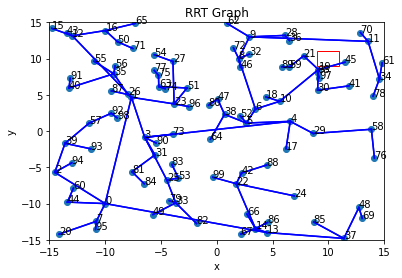

In [116]:
growth_factor = 1
max_num_nodes = 100
start_state = state2D(-10, -10)
goal_states = [state2D(10, 10)]
state_generator = randomCartesianStateGenerator([-15, -15], [15, 15], 2)
goal_checker = goalCheckerCartesian(goal_states, [1, 1])
rrt = RapidRandomTrees(growth_factor, max_num_nodes, start_state, goal_states, state_generator, goal_checker)

(resulting_tree, result) = rrt.searchNoGrowthFactor()
print(len(resulting_tree), result)

# Plotting the tree
plot_RRT(resulting_tree, goal_states, [-15, 15], [-15, 15])

In [102]:
for node in resulting_tree:
    if node.node_number == 10:
        print(node)

((10.1, 10.19)) --- neighbors: [[(1.51, 10.22)]]
